# Fine-Grained Curriculum Design from Dataset Aggregation Perspective

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('../')
import scriptinit
import numpy as np
import numpy.random as npr
import numpy.linalg as npla
from matplotlib.pyplot import *
from pyrl.algorithms.uvfa import *
from pyrl.algorithms.valueiter import *
from pyrl.tasks.gridworld import *
from pyrl.algorithms.nn import *
from pyrl.agents.agent import *
from pyrl.agents.multitask import *
from pyrl.algorithms.multitask import *
import pyrl.agents.arch as arch
from pyrl.prob import *
from pyrl.utils import *
from pyrl.evaluate import *

Couldn't import dot_parser, loading of dot files will not be possible.


In [21]:
def showV(v):
    imshow(v.reshape(H, W), interpolation='none')
    print v
    
def showExperience(agent):
    task_types = set(agent.experience_task)
    task_percent = dict()
    for task in task_types:
        task_percent[task] = sum([e == task for e in agent.experience_task])
    total = sum(task_percent.values())
    return {key: val / float(total) for (key, val) in task_percent.items()}

# World

[[ 0.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  0.]]


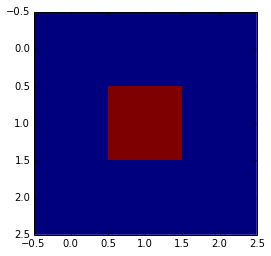

In [3]:
# world 1
H = W = 3
grid = np.zeros((H, W))
grid[1:2, 1:2] = 1.
showV(grid)

In [4]:
tasks = generate_gridworlds_fixed_start_state(grid)
tasks_cv = prob.choice(sum(tasks.values(), []), 30, replace=False)
for key in tasks:
    random.shuffle(tasks[key])
# random.shuffle(all_tasks)
# tasks = all_tasks[:4] + all_tasks[-4:]

In [5]:
tasks

{1: [(0, 0) -> (1, 0),
  (1, 0) -> (2, 0),
  (1, 0) -> (0, 0),
  (0, 0) -> (0, 1),
  (2, 2) -> (2, 1),
  (0, 2) -> (0, 1),
  (1, 2) -> (0, 2),
  (1, 2) -> (2, 2),
  (2, 2) -> (1, 2),
  (2, 1) -> (2, 0),
  (0, 1) -> (0, 2),
  (2, 1) -> (2, 2),
  (2, 0) -> (2, 1),
  (0, 1) -> (0, 0),
  (2, 0) -> (1, 0),
  (0, 2) -> (1, 2)],
 2: [(2, 2) -> (0, 2),
  (2, 2) -> (2, 0),
  (1, 2) -> (0, 1),
  (2, 1) -> (0, 1),
  (2, 1) -> (1, 0),
  (1, 0) -> (1, 2),
  (0, 1) -> (2, 1),
  (1, 2) -> (1, 0),
  (0, 2) -> (2, 2),
  (1, 0) -> (2, 1),
  (0, 1) -> (1, 2),
  (2, 0) -> (2, 2),
  (2, 1) -> (1, 2),
  (0, 1) -> (1, 0),
  (0, 0) -> (0, 2),
  (0, 2) -> (0, 0),
  (1, 0) -> (0, 1),
  (2, 0) -> (0, 0),
  (0, 0) -> (2, 0),
  (1, 2) -> (2, 1)],
 3: [(2, 2) -> (1, 0),
  (2, 1) -> (0, 2),
  (2, 0) -> (1, 2),
  (0, 0) -> (2, 1),
  (1, 0) -> (2, 2),
  (0, 2) -> (1, 0),
  (2, 0) -> (0, 1),
  (0, 1) -> (2, 0),
  (0, 1) -> (2, 2),
  (2, 2) -> (0, 1),
  (1, 2) -> (0, 0),
  (1, 0) -> (0, 2),
  (0, 2) -> (2, 1),
  (2, 1) 

In [6]:
tasks_cv

[(1, 2) -> (1, 0),
 (1, 0) -> (2, 2),
 (0, 1) -> (0, 0),
 (1, 2) -> (0, 2),
 (2, 1) -> (0, 0),
 (2, 2) -> (2, 0),
 (2, 0) -> (0, 0),
 (0, 2) -> (2, 0),
 (0, 0) -> (2, 0),
 (2, 0) -> (1, 2),
 (1, 0) -> (0, 0),
 (0, 1) -> (2, 1),
 (2, 1) -> (2, 2),
 (0, 1) -> (2, 2),
 (2, 2) -> (0, 2),
 (0, 2) -> (2, 2),
 (0, 0) -> (2, 1),
 (1, 0) -> (0, 1),
 (2, 0) -> (2, 2),
 (1, 0) -> (1, 2),
 (1, 0) -> (2, 0),
 (2, 1) -> (1, 0),
 (2, 2) -> (2, 1),
 (0, 1) -> (2, 0),
 (0, 2) -> (2, 1),
 (0, 0) -> (0, 1),
 (2, 0) -> (0, 2),
 (1, 2) -> (2, 1),
 (1, 0) -> (2, 1),
 (1, 0) -> (0, 2)]

In [16]:
# neural network architecture.
# shared weights between state and goal due to symmetry.
def two_stream_arch(states, input_dim=H * W, output_dim=4):
    params = []
    ## agent.
    H_AGENT_DIM1 = 16
    fc_agent1 = layers.FullyConnected(input_dim, H_AGENT_DIM1, activation='relu')
    h_agent1 = fc_agent1(states[:, :input_dim])
    h_goal1 = fc_agent1(states[:, input_dim:2*input_dim]) # shared weights.
    ## combine them all!
    v_joint = T.concatenate([h_agent1, h_goal1], axis=1)
    H_JOINT_DIM = 64
    fc_joint = layers.FullyConnected(2 * H_AGENT_DIM1, H_JOINT_DIM, activation='relu')
    linear_layer = layers.FullyConnected(H_JOINT_DIM, output_dim, activation=None)
    
    output = linear_layer(fc_joint(v_joint))
    
    model = {
        'fc_agent1': fc_agent1,
        'fc_joint': fc_joint,
        'linear_layer': linear_layer
    }
    return (output, model)




In [17]:
def layered_training(dqn, learn_func, num_epochs = 1):
    for key in tasks:
        for ei in range(num_epochs):
            learn_func(dqn, tasks[key])
    
            

# Sequential Learning on Increasingly Difficult Tasks

it 0 train_performances 0.515080642147
task id 1 rewards [ 0.96837007  0.46771943  0.59189207  0.94216875  0.17514823  0.32000967
  0.95220286  0.08440547  0.59243848  0.97072787  0.28519077  0.21814971
  0.94384258  0.27572459  0.14186942  0.31143031]
task percentage {(0, 0) -> (1, 0): 1.0}

it 1 train_performances 0.515080642147
task id 2 rewards [ 0.96837007  0.46771943  0.59189207  0.94216875  0.17514823  0.32000967
  0.95220286  0.08440547  0.59243848  0.97072787  0.28519077  0.21814971
  0.94384258  0.27572459  0.14186942  0.31143031]
task percentage {(1, 0) -> (2, 0): 0.9411764705882353, (0, 0) -> (1, 0): 0.058823529411764705}

it 2 train_performances 0.515080642147
task id 3 rewards [ 0.96837007  0.46771943  0.59189207  0.94216875  0.17514823  0.32000967
  0.95220286  0.08440547  0.59243848  0.97072787  0.28519077  0.21814971
  0.94384258  0.27572459  0.14186942  0.31143031]
task percentage {(1, 0) -> (2, 0): 0.8888888888888888, (0, 0) -> (1, 0): 0.05555555555555555, (1, 0) -> 

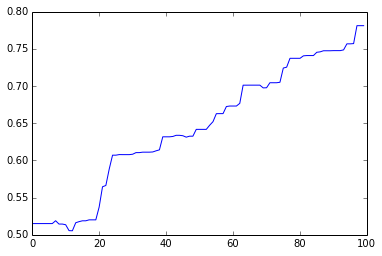

In [24]:
dqn = DQN(tasks[1][0], two_stream_arch)
def learn_func(dqn, some_tasks):
    learner = SingleLearnerSequential(dqn, some_tasks, 
                               lr=1e-4, memory_size=250)
    train_performances = []
    for it in range(100):
        learner.run(num_epochs = 1, num_episodes = 1)
#         last_task_performance = np.zeros(len(tasks_cv))
#         for ti in range(len(tasks_cv)):
#             last_task_performance[ti] = expected_reward_tabular_normalized(dqn, tasks_cv[ti], tol=1e-4)
#         train_performances.append(np.mean(last_task_performance))
        last_task_performance = np.zeros(len(some_tasks))
        for ti in range(len(some_tasks)):
            last_task_performance[ti] = reward_tabular_normalized([some_tasks[ti].start_state], dqn, some_tasks[ti], tol=1e-4)
        train_performances.append(np.mean(last_task_performance))
        print 'it', it, 'train_performances', train_performances[-1]
        print 'task id', learner.t % len(some_tasks), 'rewards', last_task_performance
        print 'task percentage', showExperience(learner.deepQlearn)
        print
    plot(train_performances)

# layered_training(dqn, learn_func, num_epochs=1)
learn_func(dqn, tasks[1])

it 0 train_performances 0.482802906897
task id 1 rewards [ 0.96544286  0.99800045  0.09573388  0.06179375  0.22204802  0.18816236
  0.54194839  0.99076386  0.95577175  0.28313944  0.27821518  0.28959218
  0.33976833  0.30260244  0.29745123  0.91441238]
task percentage {(0, 0) -> (1, 0): 1.0}

it 1 train_performances 0.482802906897
task id 2 rewards [ 0.96544286  0.99800045  0.09573388  0.06179375  0.22204802  0.18816236
  0.54194839  0.99076386  0.95577175  0.28313944  0.27821518  0.28959218
  0.33976833  0.30260244  0.29745123  0.91441238]
task percentage {(1, 0) -> (2, 0): 0.2222222222222222, (0, 0) -> (1, 0): 0.7777777777777778}

it 2 train_performances 0.482802906897
task id 3 rewards [ 0.96544286  0.99800045  0.09573388  0.06179375  0.22204802  0.18816236
  0.54194839  0.99076386  0.95577175  0.28313944  0.27821518  0.28959218
  0.33976833  0.30260244  0.29745123  0.91441238]
task percentage {(1, 0) -> (2, 0): 0.0182648401826484, (0, 0) -> (1, 0): 0.0639269406392694, (1, 0) -> (0,

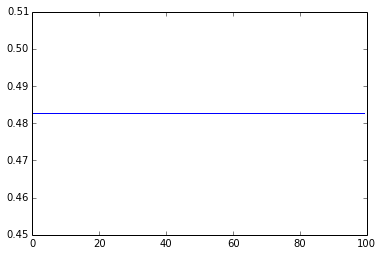

In [25]:
dqn = DQN(tasks[1][0], two_stream_arch)
def learn_func(dqn, some_tasks):
    learner = SingleLearnerSequential(dqn, some_tasks, 
                               lr=1e-4, memory_size=10000)
    train_performances = []
    for it in range(100):
        learner.run(num_epochs = 1, num_episodes = 1)
#         last_task_performance = np.zeros(len(tasks_cv))
#         for ti in range(len(tasks_cv)):
#             last_task_performance[ti] = expected_reward_tabular_normalized(dqn, tasks_cv[ti], tol=1e-4)
#         train_performances.append(np.mean(last_task_performance))
        last_task_performance = np.zeros(len(some_tasks))
        for ti in range(len(some_tasks)):
            last_task_performance[ti] = reward_tabular_normalized([some_tasks[ti].start_state], dqn, some_tasks[ti], tol=1e-4)
        train_performances.append(np.mean(last_task_performance))
        print 'it', it, 'train_performances', train_performances[-1]
        print 'task id', learner.t % len(some_tasks), 'rewards', last_task_performance
        print 'task percentage', showExperience(learner.deepQlearn)
        print
    plot(train_performances)

# layered_training(dqn, learn_func, num_epochs=1)
learn_func(dqn, tasks[1])

**Note** This explains why random policy performs worse than sequential policy. For late comers, the agent is going to collect less training example on the task than say the first task. So more learning is done for tasks that come ealier.